In [42]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/asl-alphabet-dataset/dataset/X-samples/45.jpg
/kaggle/input/asl-alphabet-dataset/dataset/X-samples/56.jpg
/kaggle/input/asl-alphabet-dataset/dataset/X-samples/89.jpg
/kaggle/input/asl-alphabet-dataset/dataset/X-samples/20.jpg
/kaggle/input/asl-alphabet-dataset/dataset/X-samples/58.jpg
/kaggle/input/asl-alphabet-dataset/dataset/X-samples/6.jpg
/kaggle/input/asl-alphabet-dataset/dataset/X-samples/76.jpg
/kaggle/input/asl-alphabet-dataset/dataset/X-samples/71.jpg
/kaggle/input/asl-alphabet-dataset/dataset/X-samples/5.jpg
/kaggle/input/asl-alphabet-dataset/dataset/X-samples/8.jpg
/kaggle/input/asl-alphabet-dataset/dataset/X-samples/84.jpg
/kaggle/input/asl-alphabet-dataset/dataset/X-samples/85.jpg
/kaggle/input/asl-alphabet-dataset/dataset/X-samples/67.jpg
/kaggle/input/asl-alphabet-dataset/dataset/X-samples/82.jpg
/kaggle/input/asl-alphabet-dataset/dataset/X-samples/30.jpg
/kaggle/input/asl-alphabet-dataset/dataset/X-samples/97.jpg
/kaggle/input/asl-alphabet-dataset/dataset/

In [43]:
DATA_DIR = '/kaggle/input/asl-alphabet-dataset/dataset'


In [44]:
import os
import pandas as pd

images = []
labels = []

for label in os.listdir(DATA_DIR):
    label_path = os.path.join(DATA_DIR, label)
    if os.path.isdir(label_path):
        for file in os.listdir(label_path):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                images.append(os.path.join(label_path, file))
                labels.append(label)

df = pd.DataFrame({
    'filename': images,
    'label': labels
})

print("Total images:", len(df))
print("Number of classes:", df['label'].nunique())
df.head()


Total images: 2427
Number of classes: 24


,filename,label
0,/kaggle/input/asl-alphabet-dataset/dataset/X-s...,X-samples
1,/kaggle/input/asl-alphabet-dataset/dataset/X-s...,X-samples
2,/kaggle/input/asl-alphabet-dataset/dataset/X-s...,X-samples
3,/kaggle/input/asl-alphabet-dataset/dataset/X-s...,X-samples
4,/kaggle/input/asl-alphabet-dataset/dataset/X-s...,X-samples


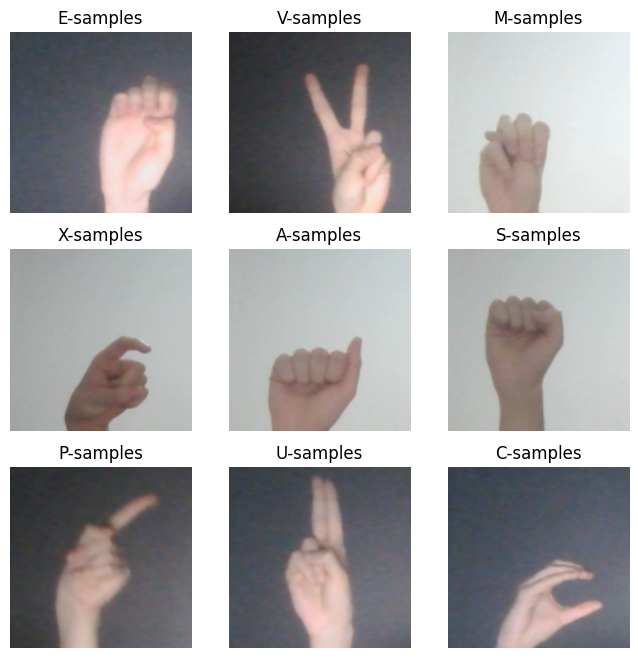

In [45]:
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint



sample_df = df.sample(9)
plt.figure(figsize=(8,8))
for i, row in enumerate(sample_df.itertuples()):
    img = plt.imread(row.filename)
    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.title(row.label)
    plt.axis('off')
plt.show()


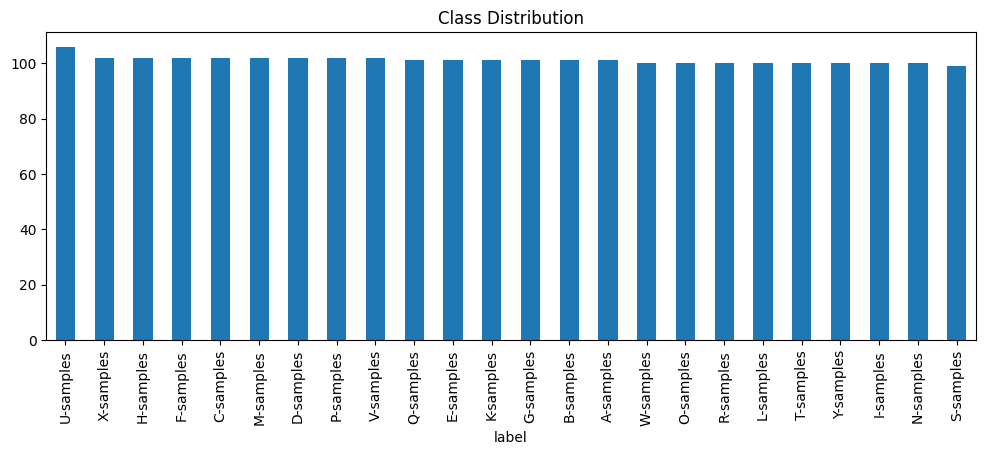

In [46]:
df['label'].value_counts().plot(kind='bar', figsize=(12,4), title='Class Distribution')
plt.show()


In [47]:
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

print("Train size:", len(train_df))
print("Validation size:", len(val_df))


Train size: 1941
Validation size: 486


In [48]:
IMAGE_SIZE = (96, 96)  # better detail for fingers
BATCH_SIZE = 32

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_data = val_gen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 1941 validated image filenames belonging to 24 classes.
Found 486 validated image filenames belonging to 24 classes.


In [49]:
NUM_CLASSES = len(train_data.class_indices) 
print("Number of classes:", NUM_CLASSES)

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(96,96,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')  # uses manual NUM_CLASSES
])

model.compile(
    optimizer=Adam(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Number of classes: 24


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,734,872 (6.62 MB)

 Trainable params: 1,734,872 (6.62 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        filepath='/kaggle/working/best_asl_model.h5',
        monitor='val_accuracy',
        save_best_only=True
    )
]


In [51]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=callbacks
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.0416 - loss: 3.1888

61/61 ━━━━━━━━━━━━━━━━━━━━ 15s 232ms/step - accuracy: 0.0415 - loss: 3.1887 - val_accuracy: 0.0412 - val_loss: 3.1780
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.0333 - loss: 3.1787

61/61 ━━━━━━━━━━━━━━━━━━━━ 14s 226ms/step - accuracy: 0.0333 - loss: 3.1787 - val_accuracy: 0.0453 - val_loss: 3.1780
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 14s 226ms/step - accuracy: 0.0493 - loss: 3.1780 - val_accuracy: 0.0432 - val_loss: 3.1773
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 21s 230ms/step - accuracy: 0.0486 - loss: 3.1814 - val_accuracy: 0.0432 - val_loss: 3.1780
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 14s 222ms/step - accuracy: 0.0552 - loss: 3.1795 - val_accuracy: 0.0432 - val_loss: 3.1779
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 14s 227ms/step - accuracy: 0.0434 - loss: 3.1779 - val_accuracy: 0.0432 - val_loss: 3.1780


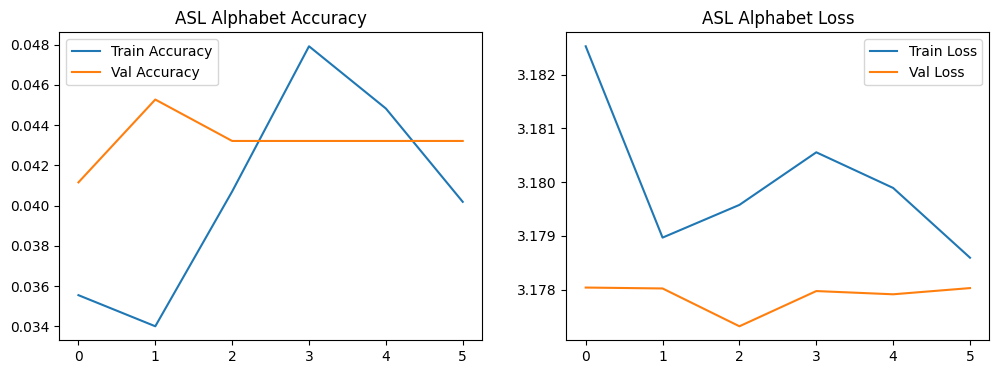

In [52]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('ASL Alphabet Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('ASL Alphabet Loss')

plt.show()


In [53]:
model.save('/kaggle/working/asl_fingerspelling_model.keras')
